---
# Running OBRWR on CIBN data
---

### Imports

In [20]:
import pickle

import numpy as np
import networkx as nx
import pandas as pd
from obrwr import obrwr_new as ob
#from obrwr_new import solution_parser as sp
import matplotlib.pyplot as plt


from statsmodels.stats.multitest import fdrcorrection

### Building subgraph and retrieving the largest connected component

Here are the different constants related to paths, experiment name etc ...

In [21]:
file_name_PPI = "human.binary.nr0.95.connected.noself.gr"
file_name_signor = "signor_mapped_tyr_nodup.tsv"
back_path = "../"
experiment = 'CIBN'
sensitive_proteins_file = experiment+"/os_sensitive_CIBN_withval.tsv"
large_inv_file = "Large/large_invadosome_protein_list.txt"
large_foc_file = "Large/large_focal_protein_list.txt"

Loading the list of sensitive proteins.

In [22]:
df = pd.read_csv(back_path+"05_Output/"+sensitive_proteins_file,sep='\t',index_col=0)
df.head()

,ACC,B5 - B0,B20 - B0,B20 - B5
Entry,,,,
E2QXI3,AIMP1_HUMAN,0.707308,0.766384,0.000000
E2R9A2,COPB_HUMAN,0.000000,-1.316144,-1.277461
E2QUR2,SYEP_HUMAN,0.000000,0.868875,0.610983
E2RH59,GNPI2_HUMAN,0.000000,-1.525599,0.000000
E2RSP4,SYK_HUMAN,0.000000,0.987616,0.000000


Loading the PPI as an edge list DataFrame

In [23]:
edge_list = pd.read_csv(back_path+"01_Reference/"+file_name_PPI,sep='\t',header=None)
edge_list.columns = ["source","target"]
edge_list.head()

,source,target
0,A0A024R0L9_HUMAN,RBPMS_HUMAN
1,A0A024R0L9_HUMAN,SHD_HUMAN
2,RBPMS_HUMAN,FBLN4_HUMAN
3,RBPMS_HUMAN,KR122_HUMAN
4,RBPMS_HUMAN,PO6F2_HUMAN


Building NetworkX graphs for both PPI and Signor

In [24]:
complete_G = nx.from_pandas_edgelist(edge_list)
signor = pd.read_csv(back_path+"00_InputData/"+file_name_signor,sep='\t')
signor.columns = ["source","target"]
signor = nx.from_pandas_edgelist(signor,create_using=nx.DiGraph)

Loading datasets of proteins detected in Invadosome + Focal Adhesion (lamellipodia)

In [25]:
dfInv = pd.read_csv(back_path+"00_InputData/"+large_inv_file,sep="\t",header=None)
dfFA = pd.read_csv(back_path+"00_InputData/"+large_foc_file,sep="\t",header=None)

## Building Graph Signor + PPI

PPI subgraph of interest (Proteins in Inva. + Proteins in FA. + sensitive proteins)

In [26]:
list_of_nodes = np.unique(list(dfInv[0])+list(dfFA[0])+list(df['ACC']))
subG = complete_G.subgraph(list_of_nodes)
print("Number of nodes :",len(subG.nodes))
print("Number of connected components :", nx.number_connected_components(subG))
subG = subG.subgraph(max(nx.connected_components(subG), key=len)).copy()
print("Number of nodes :",len(subG.nodes))
print("Number of connected components :", nx.number_connected_components(subG))
nx.set_node_attributes(subG, {node: (node in list(dfInv[0])) for node in subG.nodes}, "Invadosome")
nx.set_node_attributes(subG, {node: (node in list(dfFA[0])) for node in subG.nodes}, "FocalAdhesion")
nx.set_node_attributes(subG, {node: (node in list(df['ACC'])) for node in subG.nodes}, experiment)

Number of nodes : 1508
Number of connected components : 254
Number of nodes : 1250
Number of connected components : 1


Retrieving Signor phosphorylations on same set of protein

In [27]:
signor_large = signor.subgraph(subG.nodes())
signor_large = signor.subgraph(max(nx.connected_components(nx.Graph(signor_large)), key=len))
print(f'Size of signor subgraph : {len(signor_large)}')
print(f'N° of edges in signors sub. : {len(signor_large.edges())}')
print(f"Number of connected components : {nx.number_connected_components(nx.Graph(signor_large))}")

Size of signor subgraph : 142
N° of edges in signors sub. : 242
Number of connected components : 1


Joining the two 

In [28]:
subG = subG.to_directed()
l = []
for n in signor_large.nodes:
    l +=  [n] + [i for i in subG.neighbors(n)]
l = list(np.unique(l+list(df['ACC'])))
subG = subG.subgraph(l)

subG = subG.copy()
subG = nx.compose(signor_large,subG)

In [29]:
print(f'Size of signor subgraph : {len(subG)}')
print(f'N° of edges in signors sub. : {len(subG.edges())}')
print(f"Number of connected components : {nx.number_connected_components(nx.Graph(subG))}")

Size of signor subgraph : 654
N° of edges in signors sub. : 4926
Number of connected components : 1


In [11]:
s = 0
for (u,v) in subG.edges():
    if not subG.has_edge(v,u):
        s += 1
print(f"Directed edges in final network : {s}")

Directed edges in final network : 162


## Time 5 - Time 0

In [12]:
time_exp = 'B5 - B0'
folder_exp = back_path+'05_Output/'+experiment+"/"
folder_rd = folder_exp + "random_"+time_exp+'/'

In [13]:
myGraph = ob.MyGraph(subG)
myGraph.set_sources(['SRC_HUMAN'],1e4)

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


[121]

In [14]:
d = {}
for i in range(len(df)):
    entr = df['ACC'][i]
    ind = df.index[i]
    val = df[time_exp][ind]
    if val > 0 :
        d[entr] = 1+val
    elif val < 0 :
        d[entr] = 1-val
myGraph.set_targets(d,self_loops=True)

AIMP1_HUMAN 1.7073084689728333
SHRM2_HUMAN 2.2522650172203313
TENS1_HUMAN 2.0643633089521067
BCAR1_HUMAN 3.650292159756233
PRAG1_HUMAN 2.5514756547570663
MK01_HUMAN 2.1429454537692294
PAXI_HUMAN 3.5872473293303955
TENS3_HUMAN 3.456815404031793
ASAP2_HUMAN 4.516980156736203
MORC3_HUMAN 1.819741629900399
PARP1_HUMAN 2.3987871617399357
MYO6_HUMAN 2.781436510790833
TWF1_HUMAN 2.2474692443506648
RL28_HUMAN 2.194404264467032


In [15]:
beta = 0.7

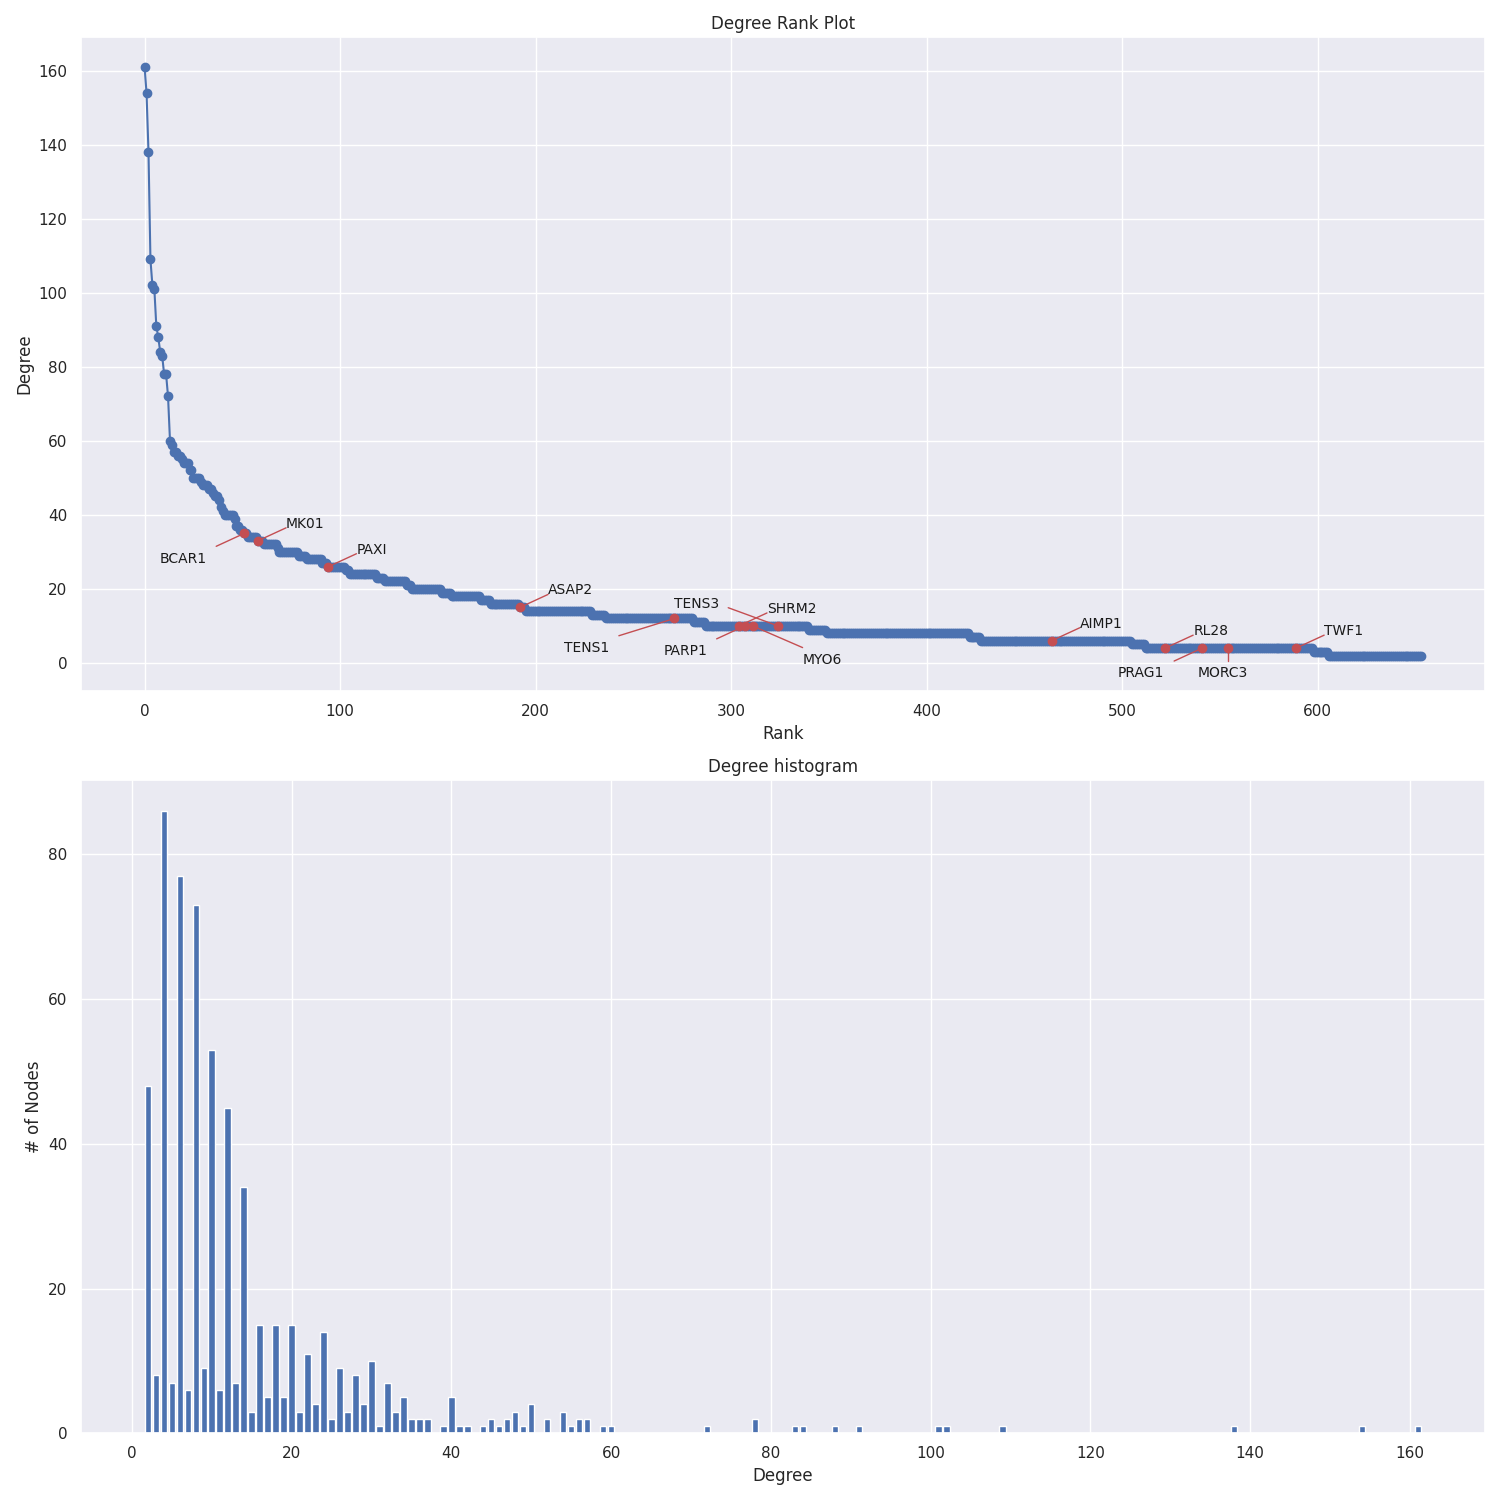

In [16]:
%matplotlib ipympl
myGraph.plot_degrees("minimal")

In [17]:
targets = nx.get_node_attributes(myGraph.subGdirected_with_annot,'Targets')
degrees = myGraph.subGdirected_with_annot.degree()
degree_sequence_sorted = sorted([d for n, d in degrees])
bins,bin_counts = myGraph.define_bins(degree_sequence_sorted)
bins_nodes = [[] for _ in bins]
target_counts = [0 for _ in bins]
for n,d in degrees:
    for i, (m,M) in enumerate(bins):
        if d <= M:
            bins_nodes[i].append(n)
            if targets[n]:
                target_counts[i] += 1
            break

In [18]:
print(bins)
print(bin_counts)
print(target_counts)

[(0, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 16), (17, 22), (23, 30), (31, 54), (54, 161)]
[48, 94, 84, 79, 62, 51, 59, 54, 54, 49, 20]
[0, 4, 1, 0, 4, 1, 1, 0, 1, 2, 0]


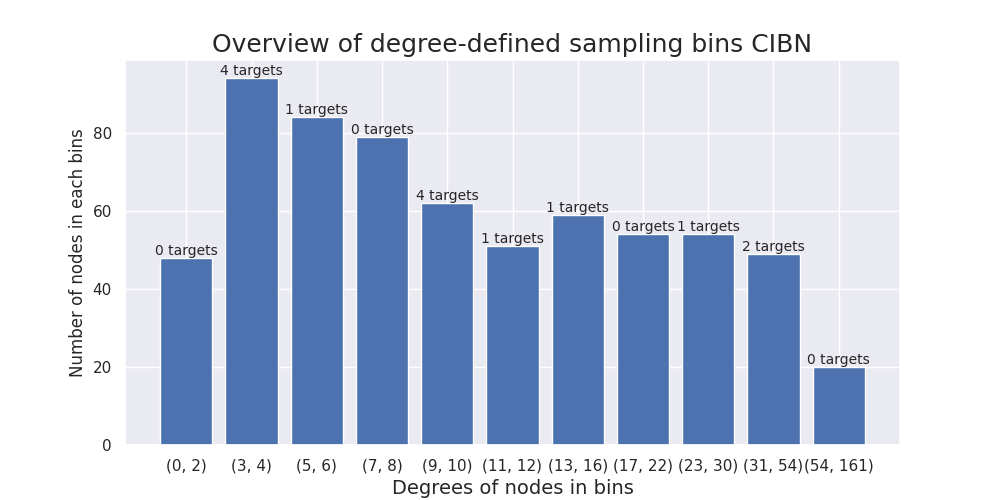

In [19]:
myGraph.plot_sampling_bins(experiment)
plt.savefig('../05_Output/CIBN/bins_T5T0.png',dpi=600)

In [25]:
distribution_scores,targets_df,epsilons_df,df_exp = myGraph.get_significative_nodes(beta,1000,experiment,folder_rd)
distribution_scores.to_csv(folder_rd+"/distribution_signor_"+experiment+time_exp+".tsv",sep='\t')
targets_df.to_csv(folder_rd+"/random_targets_signor_"+experiment+time_exp+".tsv",sep='\t',index=False)
epsilons_df.to_csv(folder_rd+"/epsilons_signor_"+experiment+time_exp+".tsv",sep='\t',index=False)
df_exp.to_csv(folder_rd+"/pvals_signor_"+experiment+time_exp+".tsv",sep='\t')

Looking for eps_crit


FileNotFoundError: [Errno 2] No such file or directory: './tmp/CIBN.mps'

In [21]:
#_ = myGraphCIBN.optimize_biased_walk_normalized(eps_crit,beta)
#myGraphCIBN.add_meta_after_optim(eps_crit,beta,"CIBN")
#myGraphCIBN.map_elements_to_names()
#myGraphCIBN.control_optimization(eps_crit,beta)

Model definition
Variable definition
Objective definition
Constr4 definition
sets defined
Constr5 definition
sets defined
Constr piisdist definition
Writing Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1228 rows, 1213 cols, 7258 nonzeros
361 rows, 346 cols, 5581 nonzeros
312 rows, 298 cols, 5511 nonzeros
Presolve : Reductions: rows 312(-1025); columns 298(-5309); elements 5511(-6356)
Solving the presolved LP
IPX model has 312 rows, 298 columns and 5511 nonzeros
Input
    Number of variables:                                298
    Number of free variables:                           0
    Number of constraints:                              312
    Number of equality constraints:                     284
    Number of matrix entries:                           5511
    Matrix range:                                       [2e-06, 3e+02]
    RHS range:                                          [2e+00, 1e+04]
    Objective range:                   

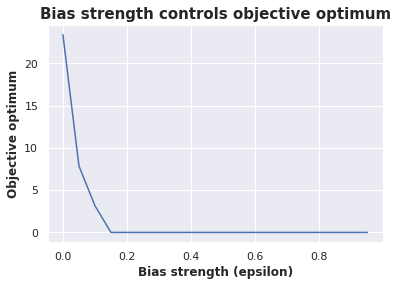

In [50]:
myGraph.map_elements_to_int()
myGraph.plot_objective_eps(beta)
myGraph.map_elements_to_names()
f = plt.gcf()
plt.title(f.axes[0].get_title(),weight='bold',fontsize=15)
plt.xlabel(f.axes[0].get_xlabel(),weight='bold',fontsize=12)
plt.ylabel(f.axes[0].get_ylabel(),weight='bold',fontsize=12)
f.savefig("../05_Output/estimate_eps/estim_eps_CIBN_t5.png",dpi=600)

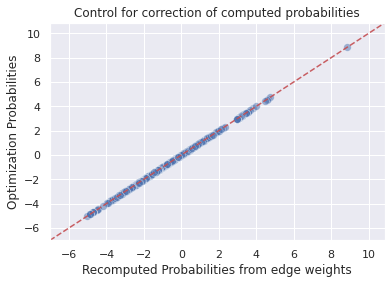

In [42]:
#eps = eps_crit
#_ = myGraphCIBN.optimize_biased_walk_normalized(eps,beta)
#myGraph.map_elements_to_int()
eps_crit,pi = myGraph.find_eps_critic(beta,1e-2)
_ = myGraph.optimize_biased_walk_normalized(eps_crit,beta)
myGraph.eps_crit = eps_crit
myGraph.add_meta_after_optim(eps_crit,beta,experiment)
myGraph.control_optimization(beta)
myGraph.map_elements_to_names()

In [44]:
myGraph.subGdirected_with_annot.nodes['PAXI_HUMAN']

{'Invadosome': True,
 'FocalAdhesion': True,
 'CIBN': True,
 'Sources': False,
 'Targets': True,
 'Stable': 26.515011010486152,
 'PiCIBN': 95.1159024345325,
 'Proba_logratioCIBN': 1.842877217973808}

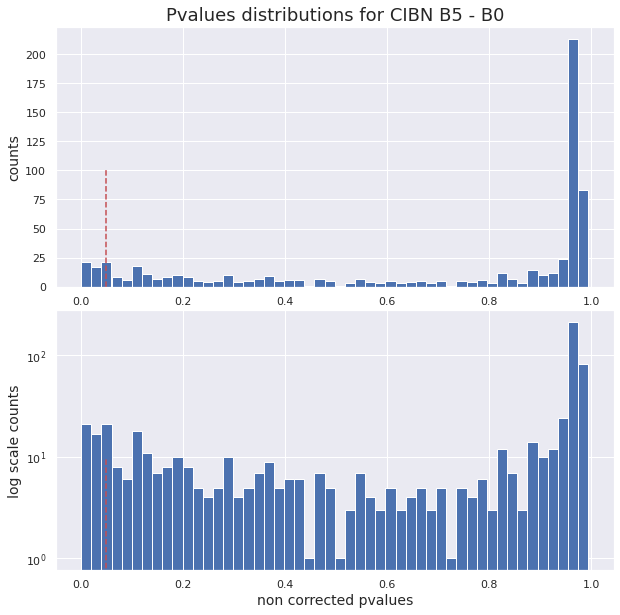

In [31]:
df_exp = pd.read_csv(folder_rd+"/pvals_signor_"+experiment+time_exp+".tsv",sep='\t')
import matplotlib.pyplot as plt
fig = plt.figure("pvalue histogram", figsize = (10,10))
axgrid = fig.add_gridspec(4,2)
ax1  = fig.add_subplot(axgrid[:2,:])
ax1.set_ylabel("counts",fontsize=14)
ax1.plot([0.05,0.05],[0,100],ls="--",c='r')
ax1.hist(df_exp["pvals"],bins=50)
ax1.set_title("Pvalues distributions for "+experiment+" " +time_exp, fontsize=18)

ax2  = fig.add_subplot(axgrid[2:,:])
ax2.hist(df_exp["pvals"],bins=50)
ax2.set_yscale("log")
ax2.plot([0.05,0.05],[0,10],ls="--",c='r')
ax2.set_xlabel("non corrected pvalues",fontsize=14)
ax2.set_ylabel("log scale counts",fontsize=14)
plt.show()

## Multitest Correction (Benjamini-Hochberg)

In [25]:
myGraph.map_elements_to_names()
d = nx.get_node_attributes(myGraph.subGdirected_with_annot,'pvals'+experiment)
nodes = []
pvals = []
for k,v in d.items():
    nodes.append(k)
    pvals.append(v)
mask, corr_pvals = fdrcorrection(pvals,method='i')
nx.set_node_attributes(myGraph.subGdirected_with_annot,{nodes[i]:corr_pvals[i] for i in range(len(nodes))},"corrected_pvals"+experiment)

(array([ 52.,  23.,  22.,  15.,  15.,   8.,  22.,  27.,  58., 412.]),
 array([0.00990099, 0.10792079, 0.20594059, 0.3039604 , 0.4019802 ,
        0.5       , 0.5980198 , 0.6960396 , 0.79405941, 0.89207921,
        0.99009901]),
 <BarContainer object of 10 artists>)

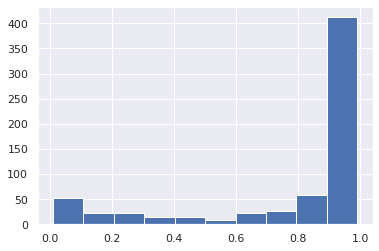

In [26]:
plt.hist(pvals)

(array([ 11.,   0.,   0.,   0.,   6.,   0.,   0.,   5.,   6., 626.]),
 array([0.58865887, 0.62880288, 0.66894689, 0.70909091, 0.74923492,
        0.78937894, 0.82952295, 0.86966697, 0.90981098, 0.949955  ,
        0.99009901]),
 <BarContainer object of 10 artists>)

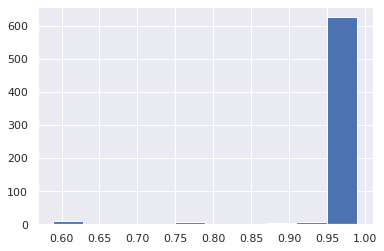

In [27]:
plt.hist(corr_pvals)

## Directed subgraph for signor CIBN

In [45]:
myGraph.map_elements_to_names()
diG = myGraph.get_directed_subgraph()
diG_from_source = myGraph.get_directed_subgraph_from_sources()
diG_edge_proba = myGraph.get_higher_edge_proba_subgraph()

{'SHRM2_HUMAN', 'ASAP2_HUMAN', 'TENS3_HUMAN', 'BCAR1_HUMAN', 'PAXI_HUMAN'}


## Saving outputs

In [46]:
nx.write_gml(diG,back_path+'05_Output/'+experiment+'/signor_dig_'+experiment+time_exp+'.gml')
nx.write_gml(diG_from_source,back_path+'05_Output/'+experiment+'/signor_digfromsrc_'+experiment+time_exp+'.gml')
nx.write_gml(diG_edge_proba,back_path+'05_Output/'+experiment+'/signor_digedge_'+experiment+time_exp+'.gml')

## Saving the global subgraph

In [47]:
nx.write_gml(myGraph.subGdirected_with_annot,back_path+'05_Output/'+experiment+'/signor_subgraph_'+experiment+time_exp+'.gml')

## Looking at epsilons

In [31]:
epsilons_df = pd.read_csv(back_path+'05_Output/'+experiment+"/epsilons_signor_"+experiment+time_exp+".tsv",sep='\t')

In [32]:
epsilons_df.head()

,0
0,0.082734
1,0.098047
2,0.098047
3,0.105703
4,0.090391


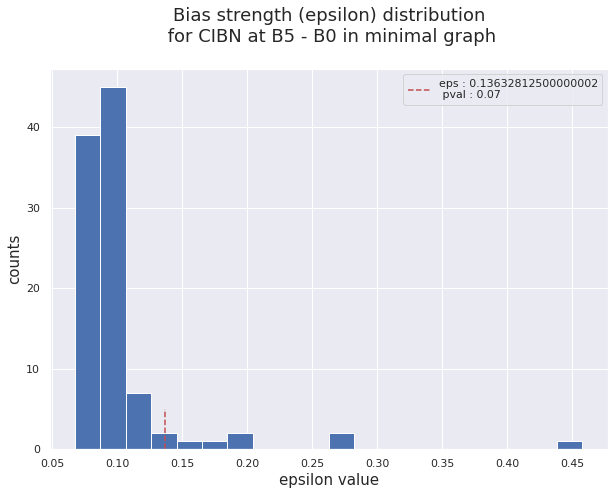

In [36]:
fig = plt.figure(figsize=(10,7))
ax = fig.subplots()
ax.hist(epsilons_df,bins=20)
ax.plot([myGraph.eps_crit,myGraph.eps_crit],[0,5],ls = "--", c="r", label = f"eps : {myGraph.eps_crit}\n pval : {np.sum(epsilons_df['0'] > myGraph.eps_crit)/100}")
ax.set_ylabel("counts",fontsize=15)
ax.set_xlabel("epsilon value",fontsize=15)
ax.set_title(f"Bias strength (epsilon) distribution\n for {experiment} at {time_exp} in minimal graph\n",fontsize=18)
plt.legend()
plt.show()

## Looking at correlation between RWR (non biased , as distance to Src) and pval

In [37]:

df_exp = pd.read_csv(back_path+'05_Output/'+experiment+"/pvals_signor_"+experiment+time_exp+".tsv",sep='\t')
df_exp.head()

,Unnamed: 0,CIBN,pvals
0,1433B_HUMAN,1.157027,0.940594
1,1433E_HUMAN,1.129518,0.940594
2,1433G_HUMAN,0.888162,0.930693
3,1433T_HUMAN,0.172123,0.623762
4,1433Z_HUMAN,4.841441,0.148515


In [38]:
import time
t0 = time.time()
myGraph.map_elements_to_int()
print(f'Time to map : {time.time() - t0}')
t0 = time.time()
myGraph.set_stable(["unbiased",beta])
print(f'Time to compute stable : {time.time() - t0}')

Time to map : 0.07164216041564941
Time to compute stable : 0.022320270538330078


In [39]:
df_pvals = pd.DataFrame({"pvals":nx.get_node_attributes(myGraph.subGdirected_with_annot,"pvals"+experiment)})
df_correlation = df_pvals.join(pd.DataFrame({"stable":nx.get_node_attributes(myGraph.subGdirected_with_annot,"Stable")}))
df_correlation.head()

,pvals,stable
0,0.742574,0.299144
1,0.891089,1.357661
2,0.930693,1.349056
3,0.118812,0.009271
4,0.029703,0.431592


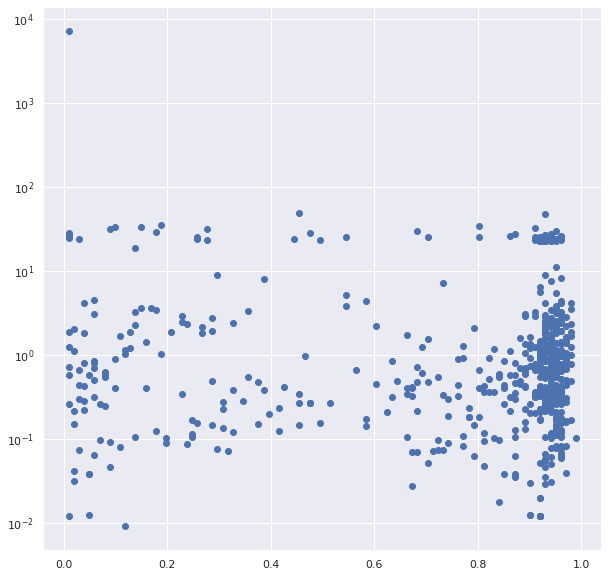

In [40]:
fig = plt.figure(figsize=(10,10))
ax = fig.subplots()
ax.scatter(df_correlation["pvals"],df_correlation["stable"])
ax.set_yscale("log")

# Time 20 - Time 0

In [13]:
time_exp = 'B20 - B0'
folder_exp = back_path+'05_Output/'+experiment+"/"
folder_rd = folder_exp + "random_"+time_exp+'/'

myGraph = ob.MyGraph(subG)
myGraph.set_sources(['SRC_HUMAN'],1e4)

d = {}
for i in range(len(df)):
    entr = df['ACC'][i]
    ind = df.index[i]
    val = df[time_exp][ind]
    if val > 0 :
        d[entr] = 1+val
    elif val < 0 :
        d[entr] = 1-val
myGraph.set_targets(d,self_loops=True)

beta = 0.7

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


AIMP1_HUMAN 1.7663835827347683
COPB_HUMAN 2.3161441996817693
SYEP_HUMAN 1.8688750120392363
SYK_HUMAN 1.98761586538183
SKT_HUMAN 1.9385326688514048
SYMC_HUMAN 1.751009019012102
MET_HUMAN 2.091126411490098
PRC2B_HUMAN 2.2910984991731382
SYRC_HUMAN 1.7299613745255016
SHRM2_HUMAN 2.671158211921899
TENS1_HUMAN 2.1635632394695037
BCAR1_HUMAN 3.4587923315644
PRAG1_HUMAN 2.992175963192629
MK01_HUMAN 2.0745174267378985
PAXI_HUMAN 2.496562102429099
TENS3_HUMAN 3.8393463118785327
ASAP2_HUMAN 4.943437511870336
PGAM5_HUMAN 2.0035490105935345
BACH_HUMAN 3.5836091191070345
SAFB2_HUMAN 2.0688795930535306
MYO6_HUMAN 2.76974576239963
RBGP1_HUMAN 3.091836362592396
TWF1_HUMAN 2.0430321693236984


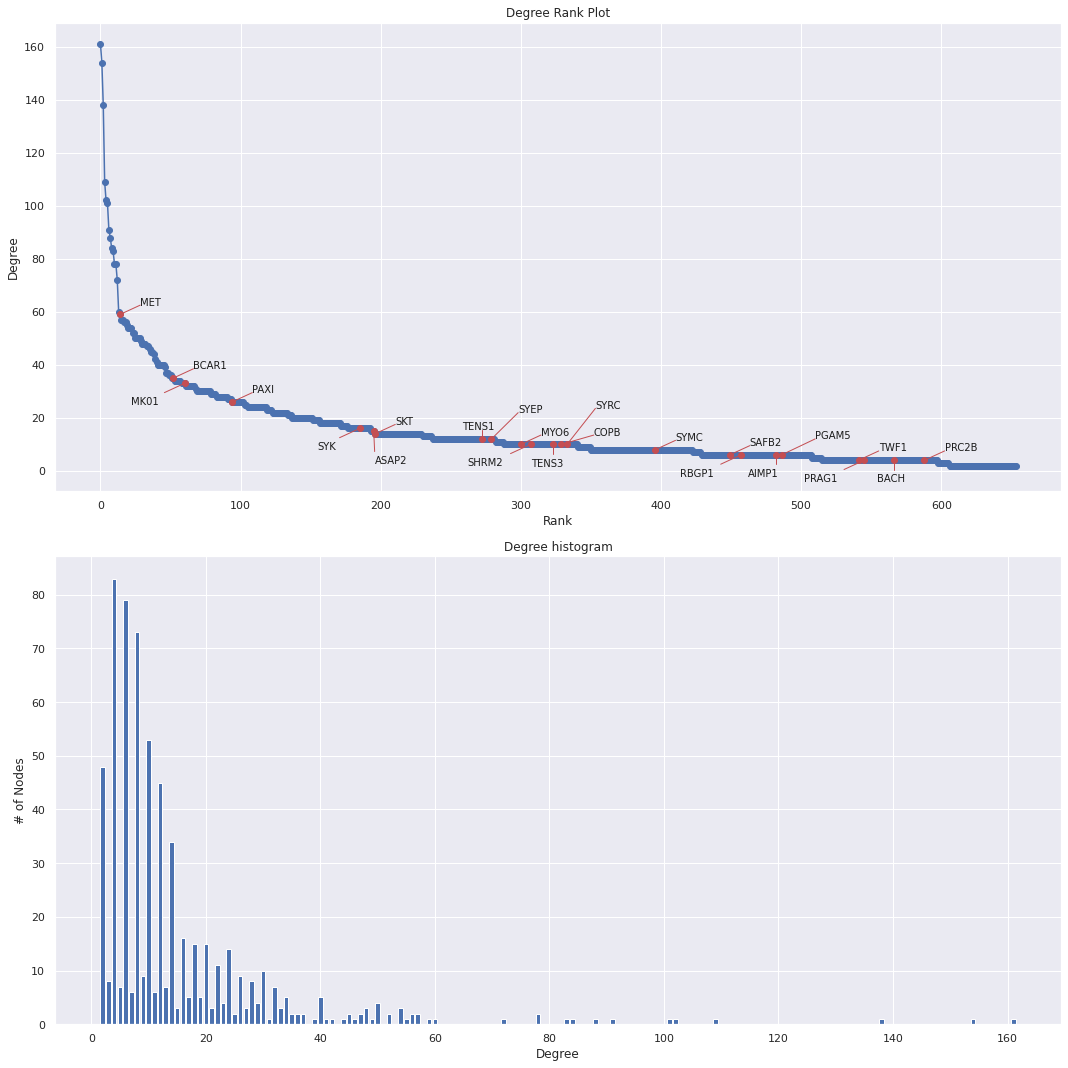

In [14]:
myGraph.plot_degrees(f"signor {experiment} {time_exp}")

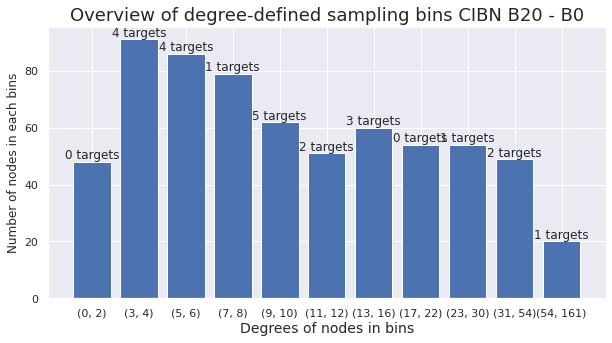

In [15]:
myGraph.plot_sampling_bins(f"{experiment} {time_exp}")

Model definition
Variable definition
Objective definition
Constr4 definition
sets defined
Constr5 definition
sets defined
Constr piisdist definition
Writing Model
Model definition
Variable definition
Objective definition
Constr4 definition
sets defined
Constr5 definition
sets defined
Constr piisdist definition
Writing Model
Model definition
Variable definition
Objective definition
Constr4 definition
sets defined
Constr5 definition
sets defined
Constr piisdist definition
Writing Model
Model definition
Variable definition
Objective definition
Constr4 definition
sets defined
Constr5 definition
sets defined
Constr piisdist definition
Writing Model
Model definition
Variable definition
Objective definition
Constr4 definition
sets defined
Constr5 definition
sets defined
Constr piisdist definition
Writing Model
Model definition
Variable definition
Objective definition
Constr4 definition
sets defined
Constr5 definition
sets defined
Constr piisdist definition
Writing Model
Model definition
Varia

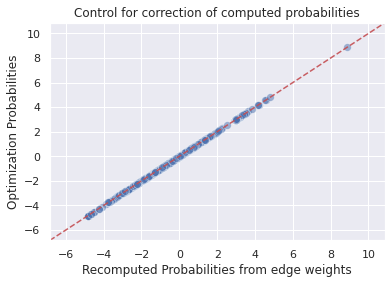

In [16]:
eps_crit,pi = myGraph.find_eps_critic(beta,1e-2)
_ = myGraph.optimize_biased_walk_normalized(eps_crit,beta)
myGraph.eps_crit = eps_crit
myGraph.add_meta_after_optim(eps_crit,beta,experiment)
myGraph.control_optimization(beta)
myGraph.map_elements_to_names()

In [ ]:
myGraph.map_elements_to_int()
myGraph.set_stable(["unbiased",beta])

distribution_scores,targets_df,epsilons_df,df_exp = myGraph.get_significative_nodes(beta,775,experiment,folder_rd)
distribution_scores.to_csv(folder_rd+"/distribution_signor_"+experiment+time_exp+".tsv",sep='\t')
targets_df.to_csv(folder_rd+"/random_targets_signor_"+experiment+time_exp+".tsv",sep='\t',index=False)
epsilons_df.to_csv(folder_rd+"/epsilons_signor_"+experiment+time_exp+".tsv",sep='\t',index=False)
df_exp.to_csv(folder_rd+"/pvals_signor_"+experiment+time_exp+".tsv",sep='\t')

myGraph.control_optimization(myGraph.eps_crit,beta)
myGraph.map_elements_to_names()

4 / 775
                    0         1         2         3         4
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198
Time for last 5 runs : 5.576130251089732 min.
Average time per 5 runs : 5.576130251089732 min.


/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


9 / 775
                    0         1         2         3         4         5  \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                    6         7         8         9  
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  
Time for last 5 runs : 5.645211911201477 min.
Average time per 5 runs : 5.610671081145605 min.


/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


14 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9         10        11  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  3.261415  2.210009   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  0.315133  2.289247   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  0.131351  0.133569   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  0.232971  0.237569   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  0.024601  0.021085   

                   12        13        14  
PP1A_HUMAN   2.539368  1.954456  2.659608  
A

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


19 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9         10        11  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  3.261415  2.210009   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  0.315133  2.289247   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  0.131351  0.133569   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  0.232971  0.237569   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  0.024601  0.021085   

                   12        13        14        15        16        17  \
PP1A_HUMAN   2

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


24 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        15        16  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.313002  3.568739   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.318376  0.296282   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.202621  0.265988   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.234249  0.222844   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.022877  0.025624   

                   17        18        19        20        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


29 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        20        21  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  3.465974  0.010704   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.462672  0.001211   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.182867  0.000080   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.235587  0.001198   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.027319  0.000007   

                   22        23        24        25        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


34 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        25        26  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  9.672691  3.258455   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.327721  0.289588   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.191704  0.181133   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.239415  0.231594   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.060048  0.023986   

                   27        28        29        30        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


39 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        30        31  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.176595  2.275482   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.419418  0.320951   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.218501  0.170000   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.218818  0.231472   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.025208  0.027153   

                   32        33        34        35        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


44 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        35        36  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.167618  0.018040   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.567950  0.002057   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.174609  0.002120   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.228556  0.001885   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.020608  0.000238   

                   37        38        39        40        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


49 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        40        41  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  5.372224  2.314860   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.341219  0.504774   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.134074  0.152777   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.222814  0.223571   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.020877  0.021431   

                   42        43        44        45        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


54 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        45        46  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.973915  3.215205   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.703735  0.297982   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.138286  0.181704   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.518745  0.236935   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.022293  0.020882   

                   47        48        49        50        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


59 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        50        51  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  0.018678  2.516643   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.001684  0.525230   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.000732  0.161517   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.002287  0.243373   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.000066  0.027417   

                   52        53        54        55        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


64 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        55        56  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.282036  2.976062   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.339989  0.587603   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.240856  0.199555   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.236511  0.227756   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.026338  0.023491   

                   57        58        59        60        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


69 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        60        61  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  5.801495  2.132926   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.310088  0.272252   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.247839  0.114865   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.245731  0.215123   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.022962  0.018341   

                   62        63        64        65        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


74 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        65        66  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.224742  2.764456   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  1.050047  0.533680   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.204449  0.141314   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.235232  0.235980   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.022625  0.024579   

                   67        68        69        70        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


79 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        70        71  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  5.801495  2.088390   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.444781  0.366016   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.187902  0.104594   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.244620  0.195878   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.029000  0.016064   

                   72        73        74        75        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


84 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        75        76  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.939458  2.230859   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.452058  0.278703   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.332872  0.341300   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.509824  0.218326   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.023663  0.020613   

                   77        78        79        80        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


89 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        80        81  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  3.213698  3.016894   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.514021  0.640375   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.138927  0.158869   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.227605  0.239098   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.023167  0.060048   

                   82        83        84        85        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


94 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        85        86  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.829030  2.320209   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.443753  0.345392   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.174830  0.218497   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.236141  0.222734   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.087944  0.025029   

                   87        88        89        90        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


99 / 775
                   0         1         2         3         4         5   \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                   6         7         8         9   ...        90        91  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.296353  2.132165   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.335207  0.514823   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.163467  0.269523   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.242348  0.222157   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.037382  0.043376   

                   92        93        94        95        

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


104 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       95        96   \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  3.121742  2.885151   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.395843  0.279791   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.159472  0.151939   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.231165  0.229874   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.025948  0.020823   

                  97        98        99        100       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


109 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       100       101  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.266533  3.012483   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.281909  0.311826   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.209957  0.848855   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.218884  0.239440   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.023117  0.036143   

                  102       103       104       105       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


114 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       105       106  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.354396  2.430296   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.436904  0.543707   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.204150  0.174848   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.230814  0.227417   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.024428  0.024045   

                  107       108       109       110       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


119 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       110       111  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.340538  2.384737   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.429069  0.291442   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.171775  0.148787   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.518745  0.229072   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.032565  0.023714   

                  112       113       114       115       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


124 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       115       116  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.007494  2.191319   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.252034  0.351506   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.848855  0.332872   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.208401  0.228039   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.087944  0.026797   

                  117       118       119       120       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


129 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       120       121  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.243123  2.432227   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.286082  0.316637   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.146691  0.138870   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.223151  0.248924   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.021735  0.021697   

                  122       123       124       125       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


134 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       125       126  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  0.558751  3.043868   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.064208  0.358237   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.001075  0.201893   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.002633  0.238247   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.000007  0.032115   

                  127       128       129       130       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


139 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       130       131  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  4.503965  3.295694   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.310215  0.296988   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.252423  0.185451   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.247227  0.227336   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.041147  0.025714   

                  132       133       134       135       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


144 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       135       136  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  1.831018  2.187638   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.529723  0.341922   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.140526  0.184047   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.138330  0.223009   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.015017  0.028896   

                  137       138       139       140       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


149 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       140       141  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  3.937689  2.291863   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.361707  0.298062   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.152413  0.151297   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.245196  0.234903   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.025898  0.031588   

                  142       143       144       145       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


154 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       145       146  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.987621  0.560031   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.276907  0.006627   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.151243  0.012256   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.218599  0.001767   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.023324  0.000024   

                  147       148       149       150       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


159 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       150       151  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.362007  1.888631   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.299057  0.242351   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.172172  0.102848   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.527665  0.210063   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.024513  0.021460   

                  152       153       154       155       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


164 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       155       156  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  3.033217  3.109707   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.281855  0.317200   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.191746  0.192285   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.225724  0.219541   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.023999  0.019671   

                  157       158       159       160       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


169 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       160       161  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.323720  2.301277   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.419416  0.519816   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.179652  0.184371   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.227478  0.227531   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.028330  0.033665   

                  162       163       164       165       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


174 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       165       166  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  3.034778  2.348181   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.334322  0.502978   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.151958  0.249851   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.241494  0.234190   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.022573  0.050182   

                  167       168       169       170       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


179 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       170       171  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  4.038358  2.184624   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.320581  0.351144   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.223115  0.135165   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.232779  0.225642   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.105327  0.021783   

                  172       173       174       175       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


184 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       175       176  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.286512  3.936329   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.511461  0.287625   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.161928  0.134083   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.230991  0.223422   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.024455  0.042268   

                  177       178       179       180       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


189 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       180       181  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  3.659212  2.102748   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.366208  0.282119   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.140879  0.146795   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.389766  0.212193   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.024762  0.023239   

                  182       183       184       185       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


194 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       185       186  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.441415  2.378124   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.521920  0.252481   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.141967  0.124829   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.235697  0.200044   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.025099  0.019837   

                  187       188       189       190       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


199 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       190       191  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.499962  3.994501   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.413902  0.537459   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.144154  0.149096   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.227137  0.235971   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.024221  0.026124   

                  192       193       194       195       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


204 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       195       196  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.017785  3.465937   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.452312  0.343238   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.223284  0.256046   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.186404  0.234703   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.044615  0.025525   

                  197       198       199       200       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


209 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       200       201  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.264163  0.683244   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.339426  0.001655   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.243440  0.017305   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.210406  0.002235   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.024485  0.000027   

                  202       203       204       205       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


214 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       205       206  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.228908  2.264426   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.275381  0.358230   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.125640  0.144388   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.227721  0.230336   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.025053  0.028186   

                  207       208       209       210       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


219 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       210       211  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.370774  2.306161   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.374406  0.562562   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.169449  0.295481   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.229653  0.235752   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.037914  0.024043   

                  212       213       214       215       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


224 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       215       216  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  3.228841  2.084388   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.337379  0.270809   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.332872  0.145679   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.235896  0.225800   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.024264  0.039995   

                  217       218       219       220       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


229 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       220       221  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  3.009414  3.118572   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.535025  0.336005   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.155204  0.127623   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.232894  0.281615   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.022936  0.024430   

                  222       223       224       225       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


234 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       225       226  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  1.979798  2.183858   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.321631  0.341067   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.104911  0.248300   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.188468  0.233860   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.017596  0.026365   

                  227       228       229       230       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


239 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       230       231  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.142800  2.925702   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.332588  0.349207   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.136156  0.154312   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.214374  0.252770   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.041019  0.023768   

                  232       233       234       235       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


244 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       235       236  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.909741  3.721899   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.346145  0.280822   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.247929  0.199864   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.234014  0.223652   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.027491  0.024313   

                  237       238       239       240       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


249 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       240       241  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.358547  4.593418   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.310722  0.290332   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.191734  0.199288   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.243334  0.231103   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.024541  0.023046   

                  242       243       244       245       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


254 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       245       246  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.304206  3.637159   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.306020  0.393334   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.200748  0.169700   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.231349  0.243159   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.024224  0.026149   

                  247       248       249       250       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


259 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       250       251  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.226298  2.453220   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.278539  0.290148   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.143298  0.140550   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.244661  0.238726   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.020955  0.025725   

                  252       253       254       255       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


264 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       255       256  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.161739  2.486002   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.281011  0.534481   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.144129  0.173054   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.224178  0.233129   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.067339  0.044635   

                  257       258       259       260       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


269 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       260       261  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.389192  2.346645   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.554562  0.301802   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.195189  0.174893   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.256372  0.239133   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.026872  0.023731   

                  262       263       264       265       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


274 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       265       266  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.284323  2.277129   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.288668  0.423734   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.136847  0.171357   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.497684  0.224041   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.024914  0.025153   

                  267       268       269       270       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


279 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       270       271  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  3.787206  3.849006   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.295438  0.288879   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.136023  0.191241   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.222881  0.219456   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.065680  0.021688   

                  272       273       274       275       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


284 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       275       276  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.241498  2.983386   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.393601  0.295958   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.201854  0.172758   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.226429  0.235613   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.023437  0.036124   

                  277       278       279       280       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


289 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       280       281  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.202030  2.269815   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.275673  0.294157   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.132803  0.140912   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.219662  0.228572   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.019516  0.025798   

                  282       283       284       285       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


294 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       285       286  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  3.046905  2.257485   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.309217  0.314098   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.191774  0.170645   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.220981  0.228460   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.023195  0.035051   

                  287       288       289       290       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


299 / 775
                  0         1         2         3         4         5    \
PP1A_HUMAN   3.207341  4.620823  2.341945  5.048736  3.009238  3.027216   
ANM1_HUMAN   0.309062  0.286204  0.294132  0.290245  0.329807  0.399064   
IF2B_HUMAN   0.137732  0.158924  0.137110  0.137892  0.341228  0.139558   
RAI14_HUMAN  0.227954  0.227600  0.227858  0.230594  0.231593  0.227437   
TACC1_HUMAN  0.023118  0.023136  0.024050  0.021201  0.022198  0.023222   

                  6         7         8         9    ...       290       291  \
PP1A_HUMAN   2.243129  2.957746  2.468551  2.252078  ...  2.439856  2.172232   
ANM1_HUMAN   0.380463  0.977767  1.794589  0.284051  ...  0.275913  0.294073   
IF2B_HUMAN   0.341300  0.205814  0.223494  0.125414  ...  0.230887  0.128324   
RAI14_HUMAN  0.228520  0.247425  0.232226  0.253663  ...  0.211018  0.227201   
TACC1_HUMAN  0.046194  0.024815  0.023519  0.022794  ...  0.031558  0.025369   

                  292       293       294       295       

/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


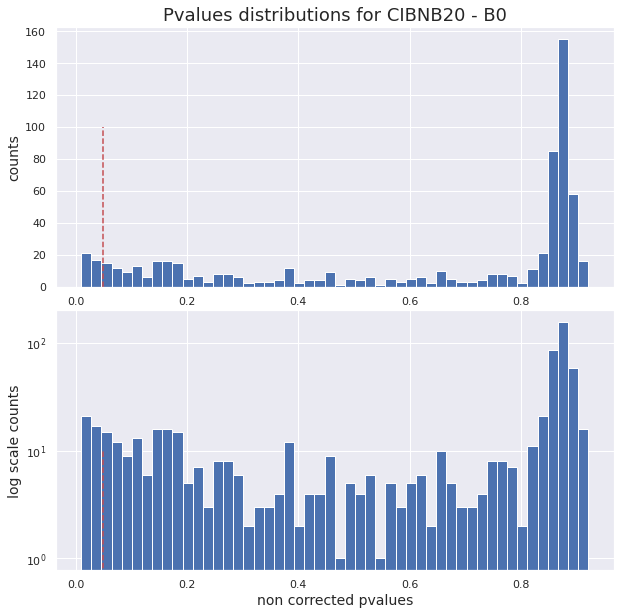

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure("pvalue histogram", figsize = (10,10))
axgrid = fig.add_gridspec(4,2)
ax1  = fig.add_subplot(axgrid[:2,:])
ax1.set_ylabel("counts",fontsize=14)
ax1.plot([0.05,0.05],[0,100],ls="--",c='r')
ax1.hist(df_exp["pvals"],bins=50)
ax1.set_title("Pvalues distributions for "+experiment+time_exp, fontsize=18)

ax2  = fig.add_subplot(axgrid[2:,:])
ax2.hist(df_exp["pvals"],bins=50)
ax2.set_yscale("log")
ax2.plot([0.05,0.05],[0,10],ls="--",c='r')
ax2.set_xlabel("non corrected pvalues",fontsize=14)
ax2.set_ylabel("log scale counts",fontsize=14)
plt.show()

## Looking at epsilons

In [17]:
epsilons_df = pd.read_csv(back_path+'05_Output/'+experiment+"/epsilons_signor_"+experiment+time_exp+".tsv",sep='\t')

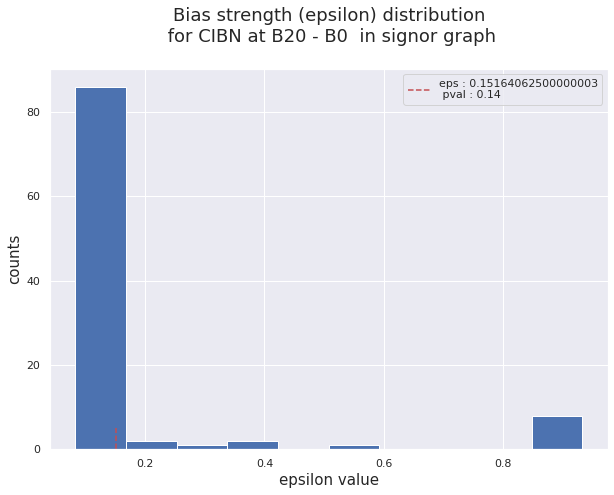

In [20]:
fig = plt.figure(figsize=(10,7))
ax = fig.subplots()
ax.hist(epsilons_df)
ax.plot([myGraph.eps_crit,myGraph.eps_crit],[0,5],ls = "--", c="r", label = f"eps : {myGraph.eps_crit}\n pval : {np.sum(epsilons_df['0'] > myGraph.eps_crit)/100}")
ax.set_ylabel("counts",fontsize=15)
ax.set_xlabel("epsilon value",fontsize=15)
ax.set_title(f"Bias strength (epsilon) distribution\n for {experiment} at {time_exp}  in signor graph\n",fontsize=18)
plt.legend()
plt.show()

## MultiTest correction (Benjamini-Hochberg Correction)

In [21]:
from statsmodels.stats.multitest import fdrcorrection

In [22]:
myGraph.map_elements_to_names()
d = nx.get_node_attributes(myGraph.subGdirected_with_annot,'pvals'+experiment)
nodes = []
pvals = []
for k,v in d.items():
    nodes.append(k)
    pvals.append(v)
mask, corr_pvals = fdrcorrection(pvals,method='i')

(array([ 74.,  66.,  31.,  18.,  24.,  24.,  21.,  25.,  36., 335.]),
 array([0.00990099, 0.1009901 , 0.19207921, 0.28316832, 0.37425743,
        0.46534653, 0.55643564, 0.64752475, 0.73861386, 0.82970297,
        0.92079208]),
 <BarContainer object of 10 artists>)

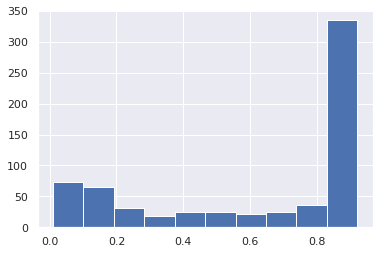

In [23]:
plt.hist(pvals)

(array([ 12.,   0.,  18.,   8.,   7.,  14.,   6.,   0.,  75., 514.]),
 array([0.53960396, 0.57772277, 0.61584158, 0.6539604 , 0.69207921,
        0.73019802, 0.76831683, 0.80643564, 0.84455446, 0.88267327,
        0.92079208]),
 <BarContainer object of 10 artists>)

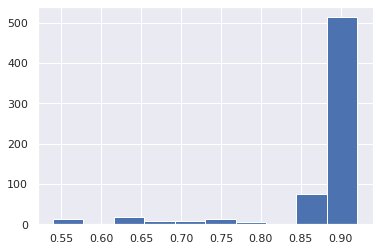

In [24]:
plt.hist(corr_pvals)

In [25]:
nx.set_node_attributes(myGraph.subGdirected_with_annot,{nodes[i]:corr_pvals[i] for i in range(len(nodes))},"corrected_pvals"+experiment)

## Directed subgraph for sigor CIBN at T20

In [17]:
myGraph.map_elements_to_names()
diG = myGraph.get_directed_subgraph()
diG_from_source = myGraph.get_directed_subgraph_from_sources()
diG_edge_proba = myGraph.get_higher_edge_proba_subgraph()

{'BACH_HUMAN', 'PAXI_HUMAN', 'RHG07_HUMAN', 'ASAP2_HUMAN', 'SHRM2_HUMAN', 'RASA1_HUMAN', 'HNRPK_HUMAN', 'GRB2_HUMAN', 'COPB_HUMAN', 'TENS3_HUMAN', 'MET_HUMAN', 'BCAR1_HUMAN'}


## Saving outputs

In [18]:
nx.write_gml(diG,back_path+'05_Output/'+experiment+'/signor_dig_'+experiment+time_exp+'.gml')
nx.write_gml(diG_from_source,back_path+'05_Output/'+experiment+'/signor_digfromsrc_'+experiment+time_exp+'.gml')
nx.write_gml(diG_edge_proba,back_path+'05_Output/'+experiment+'/signor_digedge_'+experiment+time_exp+'.gml')

## Saving the global subgraph

In [19]:
nx.write_gml(myGraph.subGdirected_with_annot,back_path+'05_Output/'+experiment+'/signor_subgraph_'+experiment+time_exp+'.gml')